# For homecage usv, try embedding spectrograms and embedding latent means, compare with manual labeling

## import modules

In [1]:
import h5py
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import umap
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

/home/vafeidis/.conda/envs/behavior/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/vafeidis/.conda/envs/behavior/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/vafeidis/.conda/envs/behavior/lib/python3.11/site-packages/uma

In [2]:
from ava.data.data_container import DataContainer
import audio_utils.io

In [3]:
%matplotlib inline

## ava project path

In [4]:
root = '/mnt/labNAS/usv_calls/usv_note_analysis/03_16_01_Cliff_low_thres_1.0'
audio_dirs = [os.path.join(root, 'audio')]
seg_dirs = [os.path.join(root, 'segs')]
proj_dirs = [os.path.join(root, 'projections')]
spec_dirs = [os.path.join(root, 'specs')]
model_filename = os.path.join(root, 'checkpoint_750.tar')
plots_dir = root
dc = DataContainer(projection_dirs=proj_dirs, spec_dirs=spec_dirs, plots_dir=plots_dir, model_filename=model_filename)

In [5]:
onsets = dc.request('onsets')
offsets = dc.request('offsets')
ava_embedding_detections = pd.DataFrame(np.vstack([onsets, offsets]).T, columns=['onsets', 'offsets'])
ava_embedding_detections = ava_embedding_detections.sort_values('onsets',ascending=True)
ava_embedding_detections

Reading field: onsets
	Done with: onsets
Reading field: offsets
	Done with: offsets


,onsets,offsets
0,0.0305,0.1010
9151,0.1445,0.2155
1,0.4520,0.4930
2,0.5150,0.6280
3,0.7509,0.8074
...,...,...
2726,4131.1934,4131.2499
2728,4134.0980,4134.1720
2729,4134.6505,4134.7335
2730,4137.4891,4137.5496


## usvseg + labels

In [7]:
usvseg_filepath = '/mnt/labNAS/usv_calls/usv_note_analysis/03_16_01_Cliff_low_thres_1.5/usvseg/usv_detections_assigned_230209_repertoire_left.csv'
usvseg_detections = pd.read_csv(usvseg_filepath)
usvseg_detections = usvseg_detections.sort_values('start',ascending=True)
usvseg_detections

,Var1,start,xEnd,duration,maxfreq,maxamp,meanfreq,cvfreq,min,max_fund,max_cand,in_song,detection_side,has_overlap,code,overlap_idx,manual_type
0,0,0.0455,0.0860,40.5,34.881,-68.18,55.359,0.4138,32891.2585,87253.6820,87253.6820,0,left,0.0000,0,NaN,7.0
7577,9647,0.1595,0.2005,41.0,22.098,-59.70,24.832,0.2551,15738.1325,36355.6587,70324.2353,0,left,0.0270,4,0.0,7.0
1,1,0.4670,0.4780,11.0,39.035,-70.90,43.612,0.1377,37213.1803,51552.8404,51552.8404,0,left,0.0000,0,NaN,10.0
2,2,0.5300,0.6130,83.0,17.393,-55.29,29.010,0.5151,15797.1524,71163.7279,71163.7279,0,left,0.0000,0,NaN,7.0
3,3,0.7659,0.7924,26.5,34.075,-71.97,57.900,0.2231,34075.0318,73099.3484,73099.3484,0,left,0.0000,0,NaN,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11569,14653,4131.2084,4131.2349,26.5,21.495,-74.97,25.683,0.4755,16398.4381,53082.5288,53082.5288,0,left,0.0115,6,5072.0,2.0
11570,14654,4134.1130,4134.1570,44.0,21.566,-66.97,21.424,0.2107,15583.0748,31250.5078,31250.5078,0,left,0.0375,6,5073.0,3.0
11571,14655,4134.6655,4134.7185,53.0,21.589,-66.34,22.725,0.2257,15547.3952,34320.2703,34320.2703,0,left,0.0395,6,5074.0,4.0
11572,14656,4137.5041,4137.5346,30.5,16.906,-73.51,20.891,0.1394,16905.8620,26189.6533,26189.6533,0,left,0.0270,6,5076.0,4.0


In [8]:
for i in range(ava_embedding_detections.shape[0]):
    ava_onset = ava_embedding_detections.iloc[i,0]
    usvseg_onset = usvseg_detections.iloc[i,1]
    if abs(ava_onset+0.015-usvseg_onset)>1e-3:
        print(f'ava detection {i} not matching with usvseg detection {i}')

In [9]:
# # check discrepency between the two detections
# # it seems ava got rid of the last 3 usvseg detections
# i_embed = 0
# i_usvseg = 0
# embed_usvseg_idx_dict = {}
# while i_embed < ava_embedding_detections.shape[0] and i_usvseg < usvseg_detections.shape[0]:
#     print(i_embed, i_usvseg)
#     embed_onset = ava_embedding_detections['onsets'].iloc[i_embed]
#     embed_offset = ava_embedding_detections['offsets'].iloc[i_embed]
#     usvseg_start = usvseg_detections['start'].iloc[i_usvseg]
#     usvseg_stop = usvseg_detections['end'].iloc[i_usvseg]
#     if abs(embed_onset+0.015-usvseg_start)<5e-5 and abs(embed_offset-0.015-usvseg_stop)<5e-5:
#         embed_usvseg_idx_dict[i_embed] = i_usvseg
#         i_embed += 1
#         i_usvseg += 1
#     else:
#         i_usvseg += 1

In [10]:
ava_embedding_detections['manual_type'] = usvseg_detections['manual_type'].iloc[:ava_embedding_detections.shape[0]].copy()
ava_embedding_detections

,onsets,offsets,manual_type
0,0.0305,0.1010,7.0
9151,0.1445,0.2155,7.0
1,0.4520,0.4930,10.0
2,0.5150,0.6280,7.0
3,0.7509,0.8074,7.0
...,...,...,...
2726,4131.1934,4131.2499,7.0
2728,4134.0980,4134.1720,7.0
2729,4134.6505,4134.7335,7.0
2730,4137.4891,4137.5496,7.0


## embed latent means

In [11]:
latent_means = dc.request('latent_means')

Reading field: latent_means
	Done with: latent_means


In [1]:
# try umap
transform = umap.UMAP(n_components=2, n_neighbors=20, min_dist=0.1, metric='euclidean', random_state=42)
embedding = transform.fit_transform(latent_means)

NameError: name 'umap' is not defined

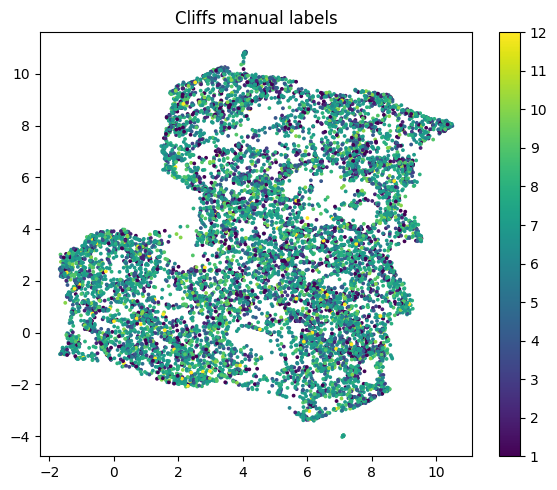

In [13]:
fig, ax = plt.subplots(figsize=(6,5))
sc = ax.scatter(embedding[:,0], embedding[:,1], s=3, c=ava_embedding_detections['manual_type'], cmap='viridis')
cbar = plt.colorbar(sc)
cbar.ax.set_yticks(np.arange(1,13))
ax.set_title('Cliffs manual labels')
plt.tight_layout()
plt.show()

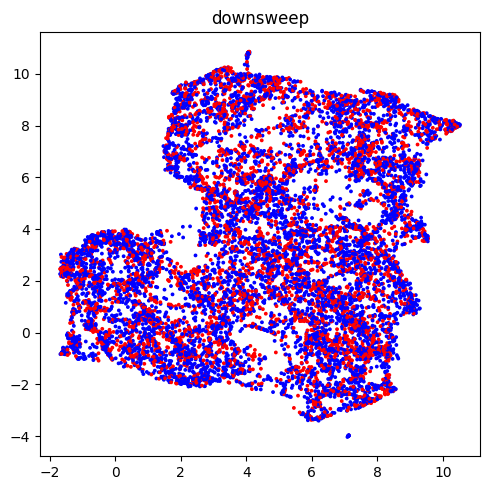

In [14]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(embedding[:,0], embedding[:,1], s=3, c=ava_embedding_detections['manual_type'].isin([1,2,3,4,5,6]), cmap='bwr')
ax.set_title('downsweep')
plt.tight_layout()
plt.show()

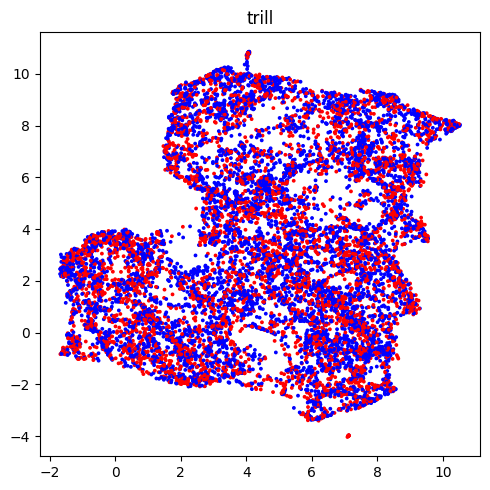

In [15]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(embedding[:,0], embedding[:,1], s=3, c=ava_embedding_detections['manual_type'].isin([7,8]), cmap='bwr')
ax.set_title('trill')
plt.tight_layout()
plt.show()

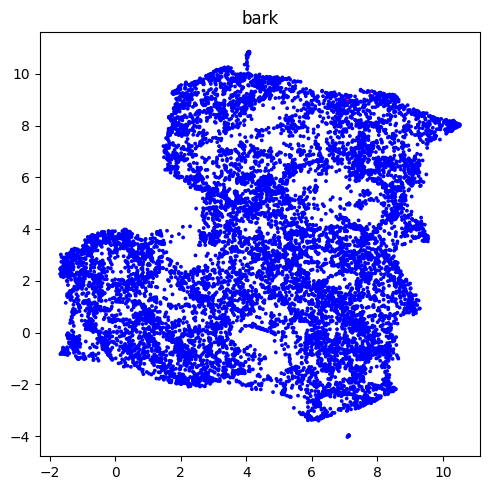

In [16]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(embedding[:,0], embedding[:,1], s=3, c=ava_embedding_detections['manual_type']==11, cmap='bwr')
ax.set_title('bark')
plt.tight_layout()
plt.show()

In [17]:
# from ava.plotting.tooltip_plot import tooltip_plot_DC
# from ava.plotting.latent_projection import latent_projection_plot_DC
# latent_projection_plot_DC(dc)
# tooltip_plot_DC(dc, num_imgs=2000)

## embed spectrograms

In [18]:
specs = dc.request('specs')

Reading field: specs
	Done with: specs


In [19]:
specs_linearized = specs.reshape(specs.shape[0], -1)
scaler = StandardScaler()
specs_linearized_zscore = scaler.fit_transform(specs_linearized.T).T
specs_linearized_zscore.shape

(11574, 16384)

In [20]:
print(np.mean(specs_linearized_zscore, axis=1).shape)
print(np.mean(specs_linearized_zscore, axis=1))

(11574,)
[ 2.08166817e-17 -6.93889390e-18  0.00000000e+00 ... -4.85722573e-17
 -3.12250226e-17  4.16333634e-17]


In [21]:
# try umap
transform = umap.UMAP(n_components=2, n_neighbors=5, min_dist=0.1, metric='euclidean', random_state=42)
embedding = transform.fit_transform(specs_linearized_zscore)

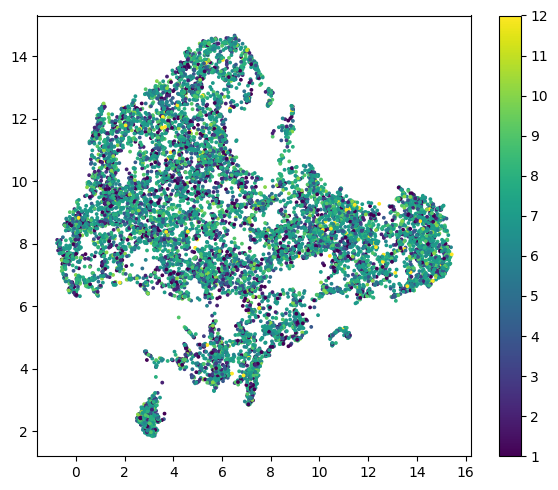

In [22]:
fig, ax = plt.subplots(figsize=(6,5))
sc = ax.scatter(embedding[:,0], embedding[:,1], s=3, c=ava_embedding_detections['manual_type'], cmap='viridis')
cbar = plt.colorbar(sc)
cbar.ax.set_yticks(np.arange(1,13))
plt.tight_layout()
plt.show()

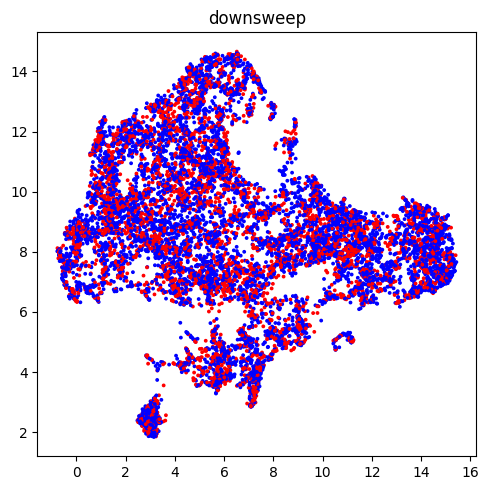

In [23]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(embedding[:,0], embedding[:,1], s=3, c=ava_embedding_detections['manual_type'].isin([1,2,3,4,5,6]), cmap='bwr')
ax.set_title('downsweep')
plt.tight_layout()
plt.show()

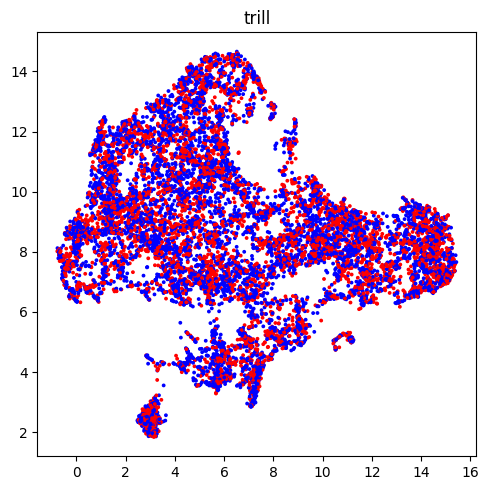

In [24]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(embedding[:,0], embedding[:,1], s=3, c=ava_embedding_detections['manual_type'].isin([7,8]), cmap='bwr')
ax.set_title('trill')
plt.tight_layout()
plt.show()

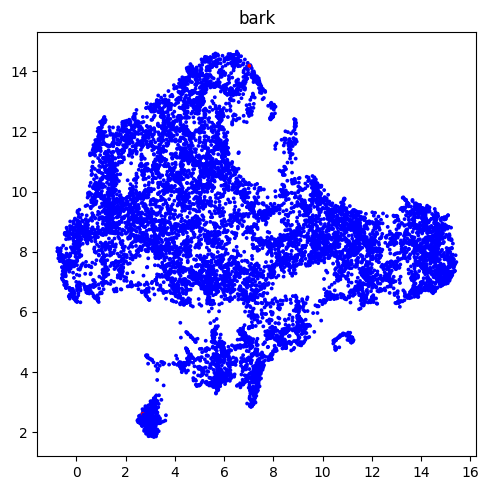

In [25]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(embedding[:,0], embedding[:,1], s=3, c=ava_embedding_detections['manual_type']==11, cmap='bwr')
ax.set_title('bark')
plt.tight_layout()
plt.show()

In [24]:
# from ava.plotting.tooltip_plot import tooltip_plot
# tooltip_plot(embedding, specs, num_imgs=4000, grid=True)